## Importations

In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ---- Paths (EDIT ONLY HERE) ----
TRAIN_CSV = "data/train.csv"
VAL_CSV   = "data/val.csv"
TEST_CSV  = "data/test.csv"
LABEL_MAP = "data/label_map.csv"
IMAGES_DIR = "data/images"
OUT_ROOT  = "torch"  # contient model0..model4

# ---- Load data ----
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

lm = pd.read_csv(LABEL_MAP)
label_to_name = dict(zip(lm["Label"].astype(int), lm["Species"].astype(str)))
num_classes = len(label_to_name)

# ---- Hyperparams (EDIT ONLY HERE TOO) ----
img_size = 128
batch_size = 64
epochs = 10
lr = 1e-3

# ---- Dataset ----
IMAGES_DIR = Path(IMAGES_DIR)

class DW(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(IMAGES_DIR / str(r["Filename"])).convert("RGB")
        y = int(r["Label"])
        return self.tfm(img), y

# ---- Transforms ----
train_tfm = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

eval_tfm = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

# ---- Loaders ----
train_loader = DataLoader(DW(train_df, train_tfm), batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(DW(val_df,   eval_tfm),  batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(DW(test_df,  eval_tfm),  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"train={len(train_df)} val={len(val_df)} test={len(test_df)} classes={num_classes}")

train=10501 val=3501 test=3507 classes=9


## Entrainement du modèle

In [2]:
import sys, json, time
from pathlib import Path
import torch.nn as nn

sys.path.append("src")
from model import WeedCNN

OUT_ROOT = Path(OUT_ROOT)

@torch.no_grad()
def eval_loss_acc(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        logits = model(x)
        loss = criterion(logits, y)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        loss_sum += loss.item() * y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, loader, criterion, opt):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        loss_sum += loss.item() * y.size(0)
    return loss_sum / total, correct / total

def train_and_save(model_id: int):
    out_dir = OUT_ROOT / f"model{model_id}"
    out_dir.mkdir(parents=True, exist_ok=True)

    model_path   = out_dir / "model.pt"
    metrics_path = out_dir / "metrics.csv"
    config_path  = out_dir / "config.json"
    summary_path = out_dir / "summary.json"

    # config.json
    config_path.write_text(json.dumps({
        "model_id": model_id,
        "model": "WeedCNN",
        "img_size": img_size,
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "num_classes": num_classes,
    }, indent=2), encoding="utf-8")

    model = WeedCNN(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_acc = 0.0
    best_epoch = 0

    metrics_path.write_text("epoch,train_loss,train_acc,val_loss,val_acc,seconds\n", encoding="utf-8")

    t0 = time.time()
    for ep in range(1, epochs + 1):
        ep_t0 = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, opt)
        va_loss, va_acc = eval_loss_acc(model, val_loader, criterion)

        sec = time.time() - ep_t0
        with open(metrics_path, "a", encoding="utf-8") as f:
            f.write(f"{ep},{tr_loss},{tr_acc},{va_loss},{va_acc},{sec}\n")

        print(f"Epoch {ep}/{epochs} | train {tr_acc*100:.2f}% | val {va_acc*100:.2f}%")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_epoch = ep
            torch.save({
                "model_state": model.state_dict(),
                "num_classes": num_classes,
                "img_size": img_size,
                "mean": (0.5, 0.5, 0.5),
                "std": (0.5, 0.5, 0.5),
            }, model_path)

    summary_path.write_text(json.dumps({
        "model_id": model_id,
        "best_val_acc": float(best_val_acc),
        "best_epoch": int(best_epoch),
        "train_seconds": float(time.time() - t0),
        "model_path": str(model_path),
    }, indent=2), encoding="utf-8")

    print(f"Saved -> {model_path} | best val {best_val_acc*100:.2f}% (epoch {best_epoch})")


model_id = 0
#* train_and_save(model_id)

## Prédiction et exemple

TEST acc = 64.61%


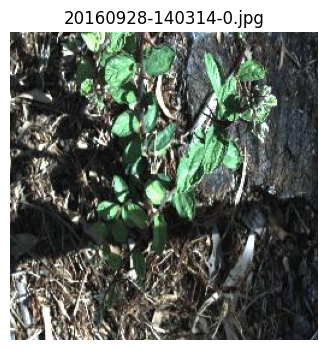

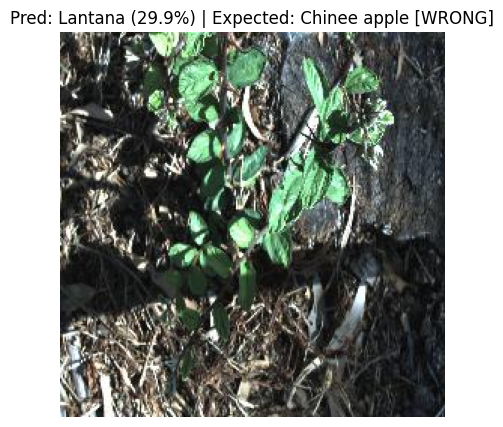

{'image': 'data\\images\\20160928-140314-0.jpg', 'pred_name': 'Lantana', 'confidence': 0.2994384467601776, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


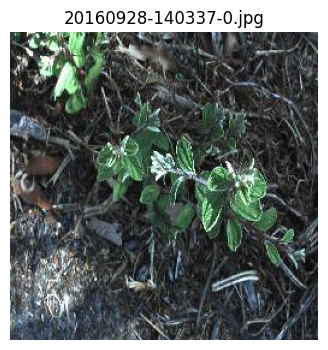

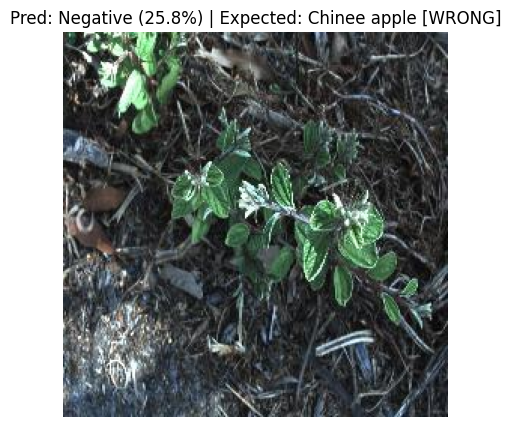

{'image': 'data\\images\\20160928-140337-0.jpg', 'pred_name': 'Negative', 'confidence': 0.2582506537437439, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


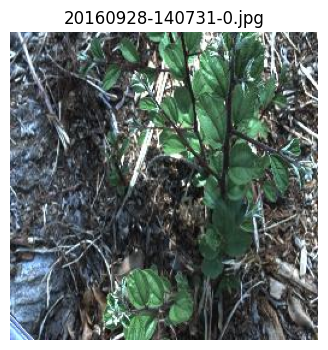

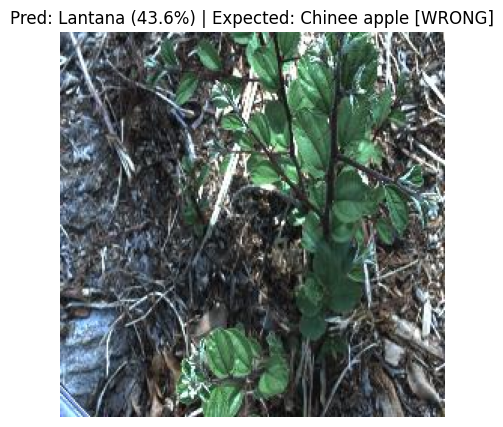

{'image': 'data\\images\\20160928-140731-0.jpg', 'pred_name': 'Lantana', 'confidence': 0.43570297956466675, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


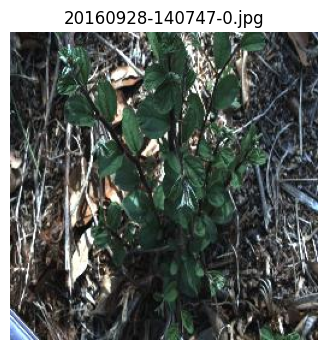

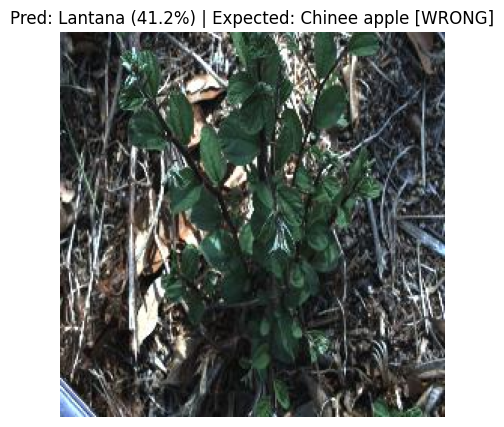

{'image': 'data\\images\\20160928-140747-0.jpg', 'pred_name': 'Lantana', 'confidence': 0.41187044978141785, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


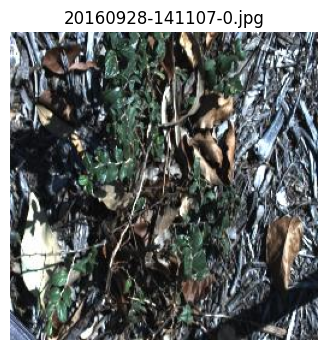

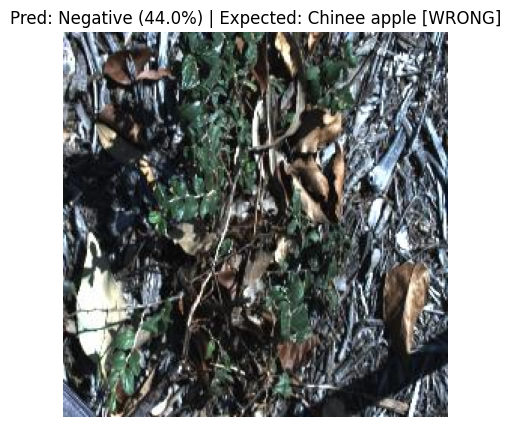

{'image': 'data\\images\\20160928-141107-0.jpg', 'pred_name': 'Negative', 'confidence': 0.4400157332420349, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


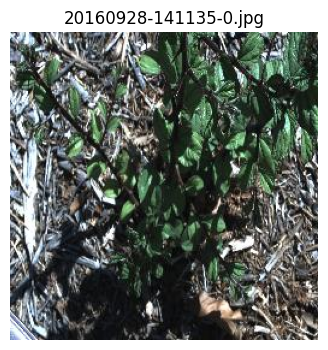

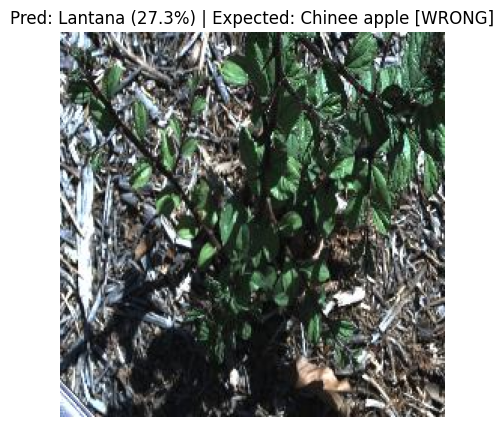

{'image': 'data\\images\\20160928-141135-0.jpg', 'pred_name': 'Lantana', 'confidence': 0.2731892764568329, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


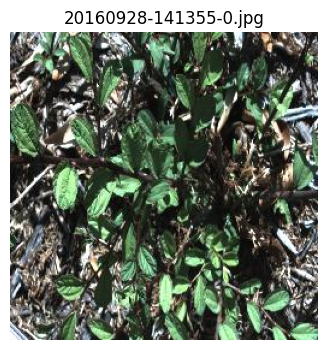

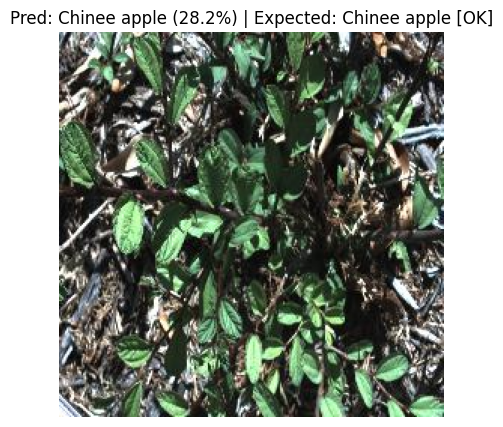

{'image': 'data\\images\\20160928-141355-0.jpg', 'pred_name': 'Chinee apple', 'confidence': 0.2817271053791046, 'expected_name': 'Chinee apple', 'match': True}
------------------------------------------------------------


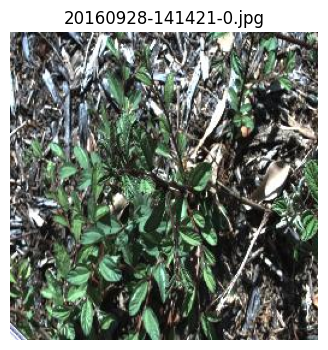

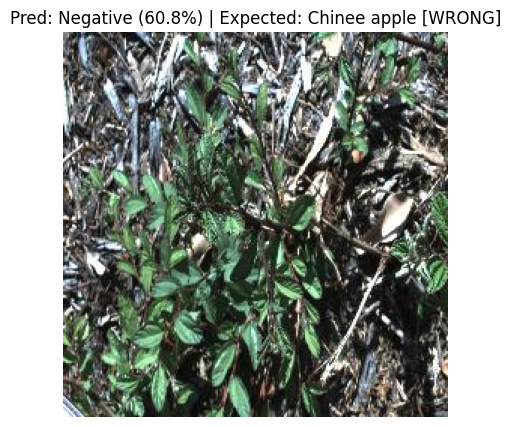

{'image': 'data\\images\\20160928-141421-0.jpg', 'pred_name': 'Negative', 'confidence': 0.6084223985671997, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


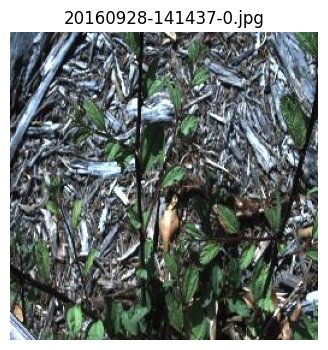

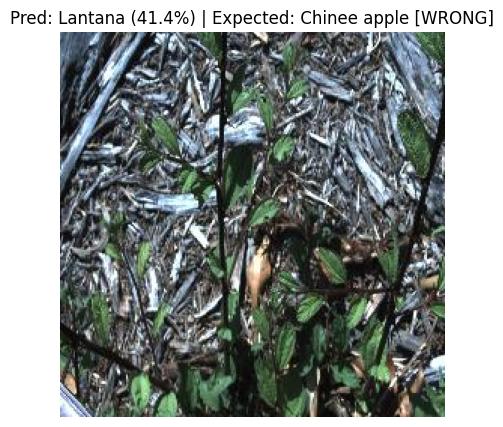

{'image': 'data\\images\\20160928-141437-0.jpg', 'pred_name': 'Lantana', 'confidence': 0.41428813338279724, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


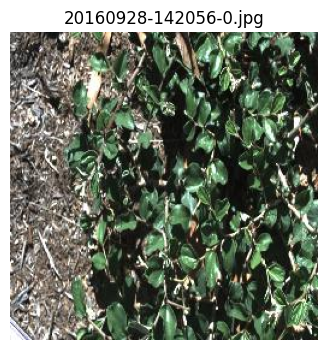

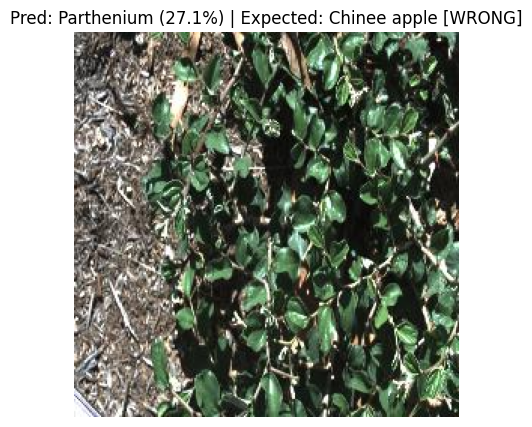

{'image': 'data\\images\\20160928-142056-0.jpg', 'pred_name': 'Parthenium', 'confidence': 0.2706601321697235, 'expected_name': 'Chinee apple', 'match': False}
------------------------------------------------------------


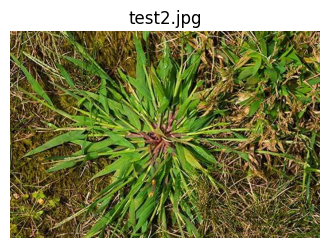

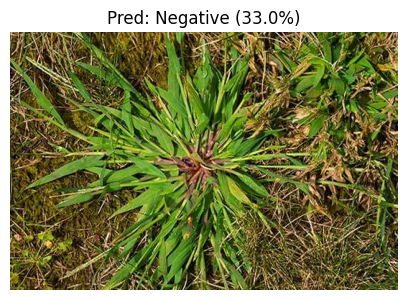

{'image': 'data\\images\\test2.jpg', 'pred_name': 'Negative', 'confidence': 0.33038952946662903, 'expected_name': None, 'match': None}
------------------------------------------------------------


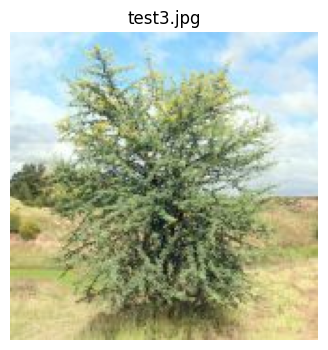

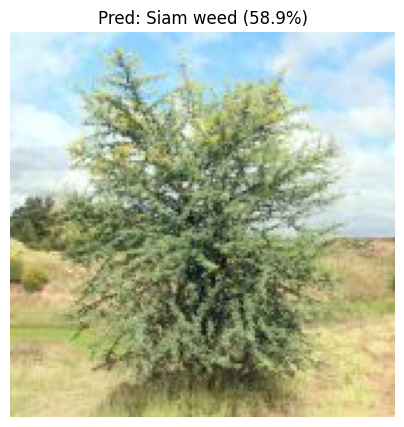

{'image': 'data\\images\\test3.jpg', 'pred_name': 'Siam weed', 'confidence': 0.5894904136657715, 'expected_name': None, 'match': None}
------------------------------------------------------------


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# --- Load checkpoint + model ---
model_path = Path(OUT_ROOT) / f"model{model_id}" / "model.pt"
ckpt = torch.load(model_path, map_location="cpu")

m = WeedCNN(num_classes=int(ckpt["num_classes"]))
m.load_state_dict(ckpt["model_state"])
m.eval()

# --- Test accuracy (quick) ---
@torch.no_grad()
def test_acc(model, loader):
    total, correct = 0, 0
    for x, y in loader:
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

print(f"TEST acc = {test_acc(m, test_loader)*100:.2f}%")

_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
fname_to_label = dict(zip(_all["Filename"].astype(str), _all["Label"].astype(int)))

mean = tuple(ckpt.get("mean", (0.5, 0.5, 0.5)))
std  = tuple(ckpt.get("std",  (0.5, 0.5, 0.5)))
size = int(ckpt.get("img_size", img_size))

pred_tfm = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def _to_label_id(expected):
    if expected is None:
        return None
    if isinstance(expected, (int, np.integer)):
        return int(expected)
    if isinstance(expected, str):
        for k, v in label_to_name.items():
            if v == expected:
                return int(k)
        raise ValueError(f"Unknown class name: {expected}")
    raise TypeError("expected must be int, str (class name), or None")

def predict(image_path: str, expected=None, show=True):
    p = Path(image_path)
    img = Image.open(p).convert("RGB")
    x = pred_tfm(img).unsqueeze(0)

    with torch.no_grad():
        logits = m(x)
        prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(np.argmax(prob))
        conf = float(prob[pred_id])

    pred_name = label_to_name.get(pred_id, str(pred_id))

    expected_id = _to_label_id(expected)
    if expected_id is None:
        expected_id = fname_to_label.get(p.name, None)

    expected_name = label_to_name.get(int(expected_id), str(expected_id)) if expected_id is not None else None
    match = (pred_id == int(expected_id)) if expected_id is not None else None

    if show:
        title = f"Pred: {pred_name} ({conf*100:.1f}%)"
        if expected_name is not None:
            status = "OK" if match else "WRONG"
            title += f" | Expected: {expected_name} [{status}]"

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.show()

    return {
        "image": str(p),
        "pred_name": pred_name,
        "confidence": conf,
        "expected_name": expected_name,
        "match": match,
    }


images = [
    "20160928-140314-0.jpg", "20160928-140337-0.jpg",
    "20160928-140731-0.jpg", "20160928-140747-0.jpg",
    "20160928-141107-0.jpg", "20160928-141135-0.jpg",
    "20160928-141355-0.jpg", "20160928-141421-0.jpg",
    "20160928-141437-0.jpg", "20160928-142056-0.jpg","siam.jpg"
]
for image in images:
    img_path = f"data/images/{image}"

    img_show = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(image)
    plt.show()

    print(predict(img_path))
    print("-" * 60)

Prédictions + métriques globales (TEST)


In [4]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

@torch.no_grad()
def get_preds_targets(model, loader):
    model.eval()
    preds, targs = [], []
    for x, y in loader:
        logits = model(x)
        p = logits.argmax(1).cpu().numpy()
        y = y.cpu().numpy()
        preds.append(p)
        targs.append(y)
    return np.concatenate(preds), np.concatenate(targs)

preds, targets = get_preds_targets(m, test_loader)

acc = accuracy_score(targets, preds)

# Macro = moyenne simple (chaque classe compte pareil)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    targets, preds, average="macro", zero_division=0
)

# Weighted = pondéré par le nombre d’images par classe
p_w, r_w, f1_w, _ = precision_recall_fscore_support(
    targets, preds, average="weighted", zero_division=0
)

print(f"TEST Accuracy            : {acc*100:.2f}%")
print(f"TEST Precision/Recall/F1 (macro)   : {p_macro:.3f} / {r_macro:.3f} / {f1_macro:.3f}")
print(f"TEST Precision/Recall/F1 (weighted): {p_w:.3f} / {r_w:.3f} / {f1_w:.3f}")

TEST Accuracy            : 64.61%
TEST Precision/Recall/F1 (macro)   : 0.559 / 0.429 / 0.445
TEST Precision/Recall/F1 (weighted): 0.624 / 0.646 / 0.604


In [5]:
names = [label_to_name[i] for i in sorted(label_to_name.keys())]
print(classification_report(targets, preds, target_names=names, digits=3, zero_division=0))

                precision    recall  f1-score   support

  Chinee apple      0.403     0.248     0.307       226
       Lantana      0.469     0.352     0.402       213
   Parkinsonia      0.527     0.285     0.370       207
    Parthenium      0.551     0.239     0.333       205
Prickly acacia      0.648     0.657     0.653       213
   Rubber vine      0.571     0.396     0.468       202
     Siam weed      0.526     0.753     0.620       215
    Snake weed      0.636     0.034     0.065       204
      Negative      0.702     0.899     0.789      1822

      accuracy                          0.646      3507
     macro avg      0.559     0.429     0.445      3507
  weighted avg      0.624     0.646     0.604      3507



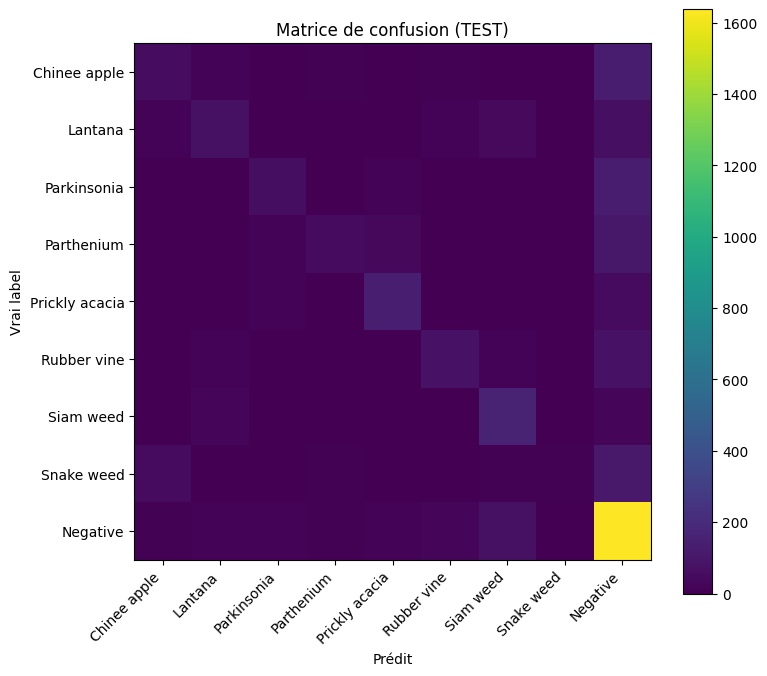

In [6]:
import matplotlib.pyplot as plt

cm = confusion_matrix(targets, preds)

plt.figure(figsize=(8,7))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion (TEST)")
plt.colorbar()
ticks = np.arange(len(names))
plt.xticks(ticks, names, rotation=45, ha="right")
plt.yticks(ticks, names)
plt.ylabel("Vrai label")
plt.xlabel("Prédit")
plt.tight_layout()
plt.show()


## Comparaison des performances

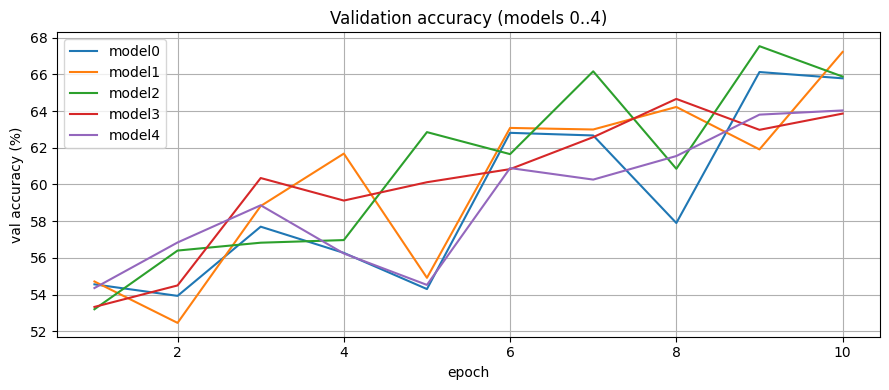

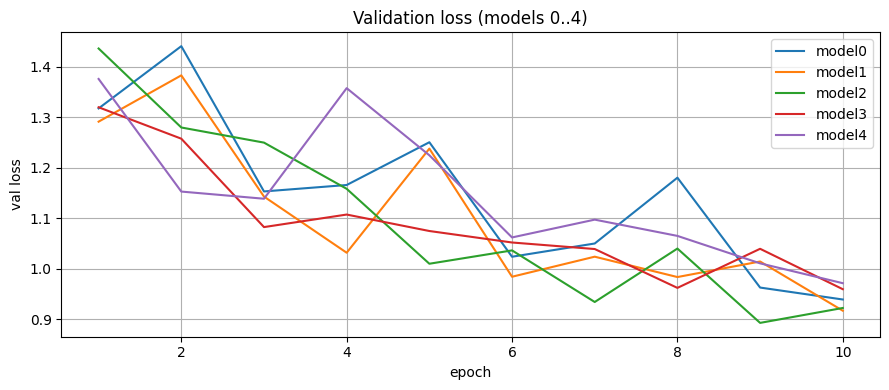

In [7]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("torch")
model_ids = [0, 1, 2, 3, 4]

# --- Load all metrics ---
metrics = {}
for mid in model_ids:
    p = ROOT / f"model{mid}" / "metrics.csv"
    if p.exists():
        metrics[mid] = pd.read_csv(p)
    else:
        print(f"Missing: {p}")

# --- Plot: Validation accuracy ---
plt.figure(figsize=(9,4))
for mid, dfm in metrics.items():
    plt.plot(dfm["epoch"], dfm["val_acc"] * 100, label=f"model{mid}")
plt.xlabel("epoch")
plt.ylabel("val accuracy (%)")
plt.title("Validation accuracy (models 0..4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot: Validation loss ---
plt.figure(figsize=(9,4))
for mid, dfm in metrics.items():
    plt.plot(dfm["epoch"], dfm["val_loss"], label=f"model{mid}")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.title("Validation loss (models 0..4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()